# Prediction of number of deaths/infected through COVID-19

This predictions are done on 10/04/2020, using data until this date.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime,timedelta

## Data

The data comes from here: https://github.com/CSSEGISandData/COVID-19/

In [2]:
df_recovered=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
df_recovered.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,5,5,10,10,10,15,18,18,29,32
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,52,67,76,89,99,104,116,131,154,165
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,46,61,61,62,90,90,90,113,237,347
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,10,10,10,16,21,26,31,39,52,58
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,1,1,1,1,2,2,2,2,2,2


In [3]:
df_confirmed=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_confirmed.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,174,237,273,281,299,349,367,423,444,484
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,243,259,277,304,333,361,377,383,400,409
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,716,847,986,1171,1251,1320,1423,1468,1572,1666
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,376,390,428,439,466,501,525,545,564,583
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,8,8,8,10,14,16,17,19,19


In [4]:
df_dead=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_dead.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,4,4,6,6,7,7,11,14,14,15
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,15,15,16,17,20,20,21,22,22,23
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,44,58,86,105,130,152,173,193,205,235
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,12,14,15,16,17,18,21,22,23,25
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


## Data manipulation

So far, I pick up five different countries to study:

- China (The first one, and therefore the reference to compare to).
- Italy (One of the biggest ones, and much more similar in social, politics and size with other Europen countries).
- Spain
- France
- US (Summing all the data from all the states together).

In [5]:
df_confirmed.loc['WholeUS'] = df_confirmed[df_confirmed['Country/Region']=='US'].sum()
df_confirmed.loc[df_confirmed.index=='WholeUS','Country/Region']='WholeUS'
df_dead.loc['WholeUS'] = df_dead[df_dead['Country/Region']=='US'].sum()
df_dead.loc[df_dead.index=='WholeUS','Country/Region']='WholeUS'

In [6]:
df_confirmed.loc[df_confirmed.index=='WholeUS',:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
WholeUS,0,WholeUS,37.0902,-95.7129,1,1,2,2,5,5,...,188172,213372,243762,275586,308853,337072,366667,396223,429052,461437


In [7]:
df_confirmed[(df_confirmed['Country/Region']=='France') & (df_confirmed['Province/State'].isnull())]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,52128,56989,59105,64338,89953,92839,98010,109069,112950,117749


In [8]:
def select_countries(df):
    df = df[(df['Country/Region']=='Spain') | (df['Country/Region']=='Italy') | 
                            ((df['Country/Region']=='France') & (df['Province/State'].isnull()))
                            |((df['Country/Region']=='China') & (df['Province/State']=='Hubei')) |
           (df['Country/Region']=='WholeUS')]
    return df

In [9]:
def prepare_dataframe(df,label='contagious'):
    """
    I create a new column "DayStart"+Country, which sets to 1 the day the number of contagious or deads equal the same as China on 1/22/20.
    This is done to be able to compare past curves (such as in China or Italy), with present ones (France, Spain or US)
    """
    if label=='contagious':
        nspain=43
        nfrance=42
        nitaly=34
        nus=44
    if label=='death':
        nspain=43
        nfrance=44
        nitaly=35
        nus=44
        
    df = df.set_index('Country/Region').drop(['Lat','Long','Province/State'],axis=1).T
    df = df.reset_index()
    df['DayStartChina']= df.index +1
    df['DayStartSpain']= df.index -nspain
    df['DayStartFrance']= df.index -nfrance
    df['DayStartItaly']= df.index -nitaly
    df['DayStartUS']= df.index -nus
    
    return df
        

In [10]:
df_contag  = select_countries(df_confirmed)
df_death  = select_countries(df_dead)

In [11]:
df_contag  = prepare_dataframe(df_contag,label='contagious')
df_death  = prepare_dataframe(df_death,label='death')

In [12]:
df_contag.head()

Country/Region,index,China,France,Italy,Spain,WholeUS,DayStartChina,DayStartSpain,DayStartFrance,DayStartItaly,DayStartUS
0,1/22/20,444,0,0,0,1,1,-43,-42,-34,-44
1,1/23/20,444,0,0,0,1,2,-42,-41,-33,-43
2,1/24/20,549,2,0,0,2,3,-41,-40,-32,-42
3,1/25/20,761,3,0,0,2,4,-40,-39,-31,-41
4,1/26/20,1058,3,0,0,5,5,-39,-38,-30,-40


## Model the data

As this is a Pandemic, we know it grows as an Exponential, until it reaches the inflexion point and it becomes a logistic function. I'm then going to consider both models for our analysis. 

In [13]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))


In [14]:
def plot_normalized_day0(df,label='Contagious',fit=True):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')


    if fit:
        xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
        yyS = np.array(df['Spain'][df['DayStartSpain']>0])
        xxSi=xxS[xxS<20]
        yySi=yyS[xxS<20]
        popt, pcov = curve_fit(exponential_model, xxSi, yySi, bounds=([-100,-1.,-100], [100., 1., 100.]))        
        poptS, pcovS = curve_fit(logistic_model, xxS, yyS, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxSi, exponential_model(xxSi, *popt), 'b-')#
        plt.plot(xxS, logistic_model(xxS, *poptS), 'b--')#
        print('Spain Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Spain Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptS))

        xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
        yyF = np.array(df['France'][df['DayStartFrance']>0])
        xxFi=xxF[xxF<22]
        yyFi=yyF[xxF<22]
        popt, pcov = curve_fit(exponential_model, xxF, yyF, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxFi, exponential_model(xxFi, *popt), 'y-')#
        poptF, pcovF = curve_fit(logistic_model, xxF, yyF, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxF, logistic_model(xxF, *poptF), 'y--')#
        print('France Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('France Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptF))

        xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
        yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
        xxWi=xxW[xxW<20]
        yyWi=yyW[xxW<20]        
        popt, pcov = curve_fit(exponential_model, xxWi, yyWi, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxWi, exponential_model(xxWi, *popt), 'm-')#
        poptW, pcovW = curve_fit(logistic_model, xxW, yyW, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxW, logistic_model(xxW, *poptW), 'm--')#
        print('US Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('US Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptW))

        xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
        yyI = np.array(df['Italy'][df['DayStartItaly']>0])
        xxIi=xxI[xxI<20]
        yyIi=yyI[xxI<20]
        popt, pcov = curve_fit(exponential_model, xxIi, yyIi) 
        plt.plot(xxIi, exponential_model(xxIi, *popt), 'g-')
        poptI, pcovI = curve_fit(logistic_model, xxI, yyI, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxI, logistic_model(xxI, *poptI), 'g--')#
        print('Italy Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Italy Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptI))

        xxC = np.array(df['DayStartChina'])
        yyC = np.array(df['China'])
        xxCi=xxC[xxC<20]
        yyCi=yyC[xxC<20]
        popt, pcov = curve_fit(exponential_model, xxCi, yyCi) 
        plt.plot(xxCi, exponential_model(xxCi, *popt), 'r-')
        poptC, pcovC = curve_fit(logistic_model, xxC, yyC, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxC, logistic_model(xxC, *poptC), 'r--')#
        print('China Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('China Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptC))

    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Exponential Model','Spain Logistic Model',
                'France Exponential Model','France Logistic Model','US Exponential Model','US Logistic Model',
            'Italy Exponential Model', 'Italy Logistic Model','China Exponential Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Spain Exponential fit: a=20.794, b=0.187, c=-21.683
Spain Logistic fit: a=4.884, b=24.459, c=167613.998
France Exponential fit: a=33.143, b=0.108, c=-40.342
France Logistic fit: a=6.397, b=34.158, c=212939.776
US Exponential fit: a=17.265, b=0.263, c=-12.559
US Logistic fit: a=4.626, b=28.641, c=595181.839
Italy Exponential fit: a=12.334, b=0.185, c=-22.123
Italy Logistic fit: a=6.203, b=29.350, c=152385.567
China Exponential fit: a=23.779, b=0.170, c=-23.587
China Logistic fit: a=4.263, b=19.697, c=67755.656


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


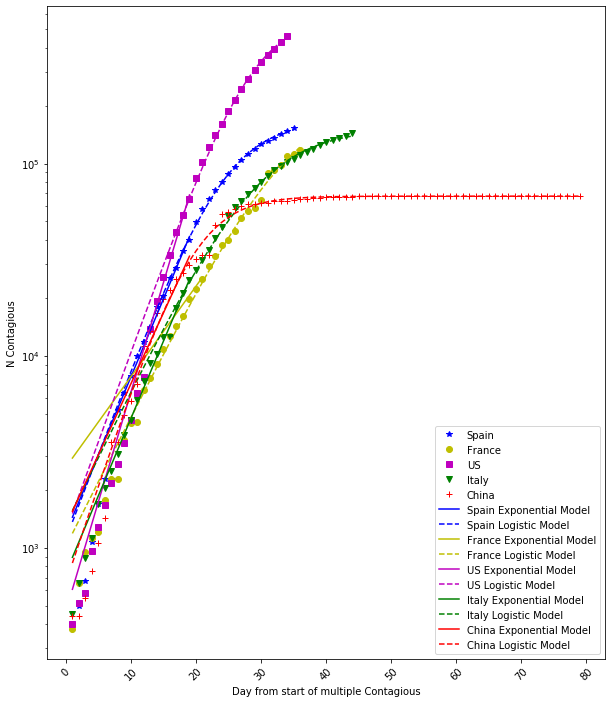

In [15]:
plot_normalized_day0(df_contag,label='Contagious')

Spain Exponential fit: a=12.257, b=0.255, c=-2.458
Spain Logistic fit: a=4.342, b=25.900, c=16875.167
France Exponential fit: a=17.162, b=0.140, c=-13.283
France Logistic fit: a=4.575, b=31.193, c=18650.555
US Exponential fit: a=9.168, b=0.269, c=1.786
US Logistic fit: a=4.183, b=32.817, c=28606.383
Italy Exponential fit: a=8.738, b=0.224, c=-5.777
Italy Logistic fit: a=5.753, b=31.137, c=20160.574
China Exponential fit: a=11.917, b=0.160, c=-8.269
China Logistic fit: a=6.648, b=25.534, c=3155.446


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


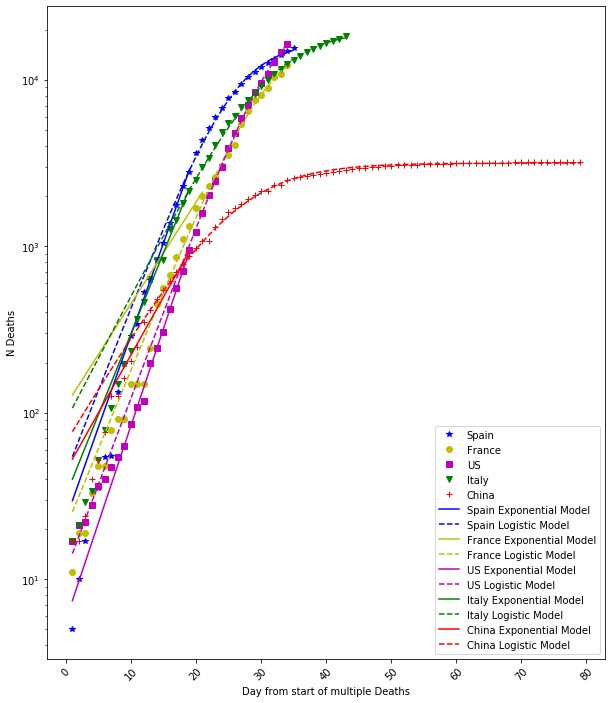

In [16]:
plot_normalized_day0(df_death,label='Deaths')

We have here fitted exponential and logistic models to the curves, and plot the above results. Let's notice than the deaths curves are much more realistic than the infected, as this depends very much on the existence of tests and different politics to measure those.

For the first time, countries such as Spain and France start to have a better logistic fit than exponential to date (31/03/2020).

## Extrapolation of the logistic model to 90 days after the first deaths/contagions

Let's use now only logistic models and assume there is going to be an inflection point of around ~25 days after the first contagions/deaths, to predict what will happen in 90 days after the first deaths / contagions.

Of course, this assumes that this inflection point is the same for all countries, and we know this will change depending on the strictness of the measurements that the different countries will take, so this is only a possible (and simple) scenario of what will happen.

In [17]:
def plot_extrapolated_logistic_model(df,label='Contagious',inflexion=25):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')

    xxPredictions = np.arange(0, 90)    
    
    xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
    yyS = np.array(df['Spain'][df['DayStartSpain']>0])
    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([4,inflexion-5,100], [10., inflexion+5, 1000000.]))       
#    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([4,1,100], [10., 100, 1000000.]))       
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'b-')
    print('Spain',popt[0],popt[1],popt[2])
    
    xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
    yyF = np.array(df['France'][df['DayStartFrance']>0])
    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([4,inflexion-5,100], [10., inflexion+5, 1000000.]))
#    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'y-')#
    print('France',popt[0],popt[1],popt[2])
    
    xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
    yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([4,inflexion-10,100], [10., inflexion+10, 1000000.])) 
#    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([4,1,100], [10.,100, 1000000.])) 
    plt.plot(xxPredictions, logistic_model(xxPredictions, *popt), 'm-')#
    print('US',popt[0],popt[1],popt[2])
    
    xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
    yyI = np.array(df['Italy'][df['DayStartItaly']>0])
    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([4,inflexion-5,100], [10., inflexion+5, 1000000.]))
#    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([4,1,100], [10., 100, 1000000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'g-')#
    print('Italy',popt[0],popt[1],popt[2])
        
    xxC = np.array(df['DayStartChina'])
    yyC = np.array(df['China'])
    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([4,10,100], [10., 100, 100000.]))
#    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'r-')#
    print('China',popt[0],popt[1],popt[2])
    
    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Logistic Model','France Logistic Model',
                'US Logistic Model','Italy Logistic Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Spain 4.8835600372484835 24.458983846067152 167613.9924680949
France 5.847470216456382 31.999999999999922 179208.48118479783
US 4.62561656908988 28.641431698780455 595181.9788713863
Italy 6.202562242364264 29.350214714217078 152385.58264183425
China 4.262648418027911 19.696732542008608 67755.65676412107


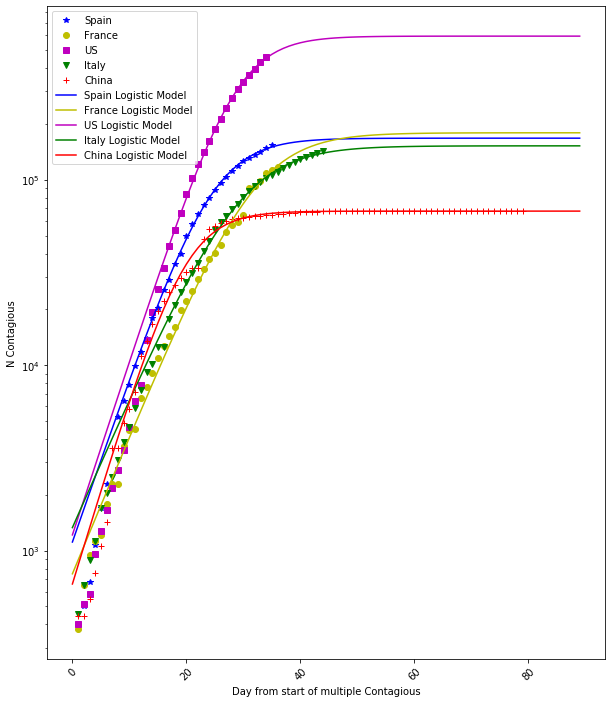

In [18]:
plot_extrapolated_logistic_model(df_contag,label='Contagious',inflexion=27)

Spain 4.341510482547967 25.899870819292616 16875.168602246835
France 4.574783706184324 31.19251388963136 18650.554411418903
US 4.182920843580203 32.81731447132577 28606.39100048997
Italy 5.75293227100478 31.136975339758035 20160.57472420897
China 6.64813999052932 25.533520940084586 3155.446261767683


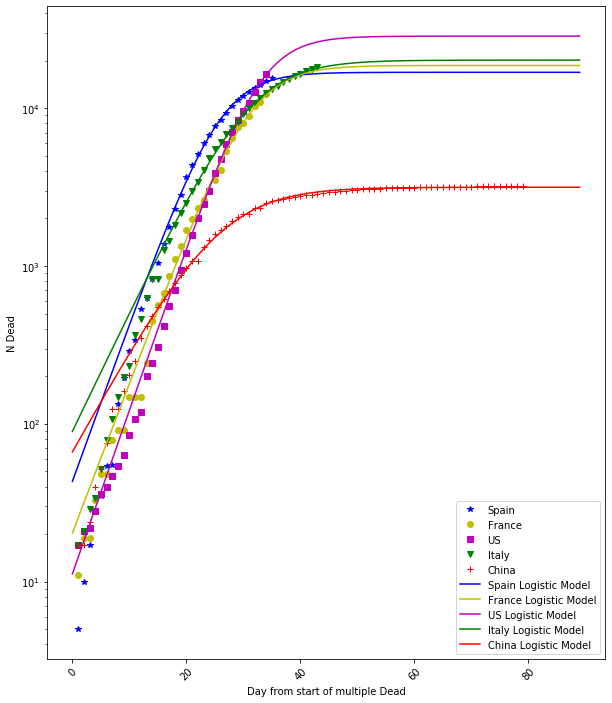

In [19]:
plot_extrapolated_logistic_model(df_death,label='Dead',inflexion=30)

I have used here, an inflexion point of 27 days for deaths, 26 for infected, based on the data from Italy.  This might change or not, based on the different measures each country takes. Based on this, the predictions are:

- ~15000 deaths in Spain, ~ 18000 in Italy, ~17000 in France and ~30000 in the US (where I had to set a much higher inflexion point of ~26+10). In China, the official number of deaths are ~2000.
- The number of infected would be of the order of ~150.000 per Spain, 130.000 per Italy, 160.000 per France and ~600.000 for the US. China would have 60.000. 
- Of course these numbers are based on the official number of infected and deaths but, this is very related to the different politics in terms of testing people and counting deaths due to CoronaVirus. Probably this is just a inferior limit.

## Things to do

- Add more countries
- Normalize by the population of each country / number of bed in hospitals per country.
- Try different scenarios (such as inflexion points)
- Continously update with new data (and hopefully expect that this will change!)